<div align='center'>
<h1 style='font-size:42px;'>Grain Optical Efficiencies</h1>
<h2 style='font-weight:400;'>Computing <code>Q_abs</code> and <code>Q_sca</code> with <code>pyGrater</code></h2>
<p><em>A concise guide to absorption & scattering efficiency tables</em></p>
</div>

---

**This tutorial covers:**
- Creating a Grain type and calculating/loading optical efficiencies
- Visualizing Q 
- Understanding and editing `parameters/general.yaml`
- Recomputing efficiency tables after parameter changes

## 1. Setup
We import the key utilities and create a `Grain` instance. By default, the code loads precomputed efficiency tables (unless `redo_Q=True`).

In [3]:
from pyGrater import stargrains as stgr
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [5]:
# Instantiate a Grain. Set redo_Q=True to force recalculation of efficiencies.
grain = stgr.Grain(redo_Q=False)  # Define a grain object

# Quick peek at arrays
Q_abs = grain.Qabs          # shape: (n_sizes, n_waves)
Q_sca = grain.Qsca          # shape: (n_sizes, n_waves)
sizes = grain.Qabs_sizes    # in microns
waves = grain.Qabs_waves    # in microns


General parameters file: /Users/prioletp/PhD/public_codes/pyGrater/pyGrater/parameters/general.yaml
Loading aC_ACAR grain properties...
aC_ACAR optical tables already exist :
--> Wavelenghts : 2000 values from 5.0e-02 to 1.5e+03 microns
--> Sizes : 2000 values from 1.0e-02 to 5.0e+03 microns


## 2. General parameters (parameters/general.yaml)
The general controls for grid resolution and ranges are stored in `parameters/general.yaml`. Key fields typically include:
- `composition`: which material to use (must exist in `parameters/material_list.txt`)
- `N_sizes`, `size_min`, `size_max`: number of grain sizes and range (µm)
- `N_waves`, `N_waves_undersampled`, `waves_min`, `waves_max`: wavelength sampling (µm)

You can inspect them from the `Grain` instance and edit the YAML file to adjust resolution and ranges.

In [6]:
print("General parameters YAML path:", grain.general_params_path)
with open(grain.general_params_path, 'r') as f:
    general_params = yaml.load(f, Loader=yaml.FullLoader)

print("\nGeneral parameters loaded:")
for k, v in general_params.items():
    print(f" - {k}: {v}")

print("\nCurrent composition:", grain.grain_composition_name)

General parameters YAML path: /Users/prioletp/PhD/public_codes/pyGrater/pyGrater/parameters/general.yaml

General parameters loaded:
 - print_information: True
 - composition: aC_ACAR
 - size_min: 0.01
 - size_max: 5000
 - waves_min: 0.05
 - waves_max: 1500
 - N_sizes: 2000
 - N_waves: 2000
 - N_waves_undersampled: 300
 - star_name: BPic

Current composition: aC_ACAR


Tip:
- After editing `general.yaml` (e.g., changing `N_sizes` or `waves_max`), recreate the `Grain` with `redo_Q=True` to regenerate the efficiency tables:
```python
grain = stgr.Grain(redo_Q=True)
```
This will recompute Q_abs and Q_sca and write them to the `efficiencies/` folder.

## 3. Quick 1D inspections
Plot Q vs wavelength for a selected size, and Q vs size for a selected wavelength.

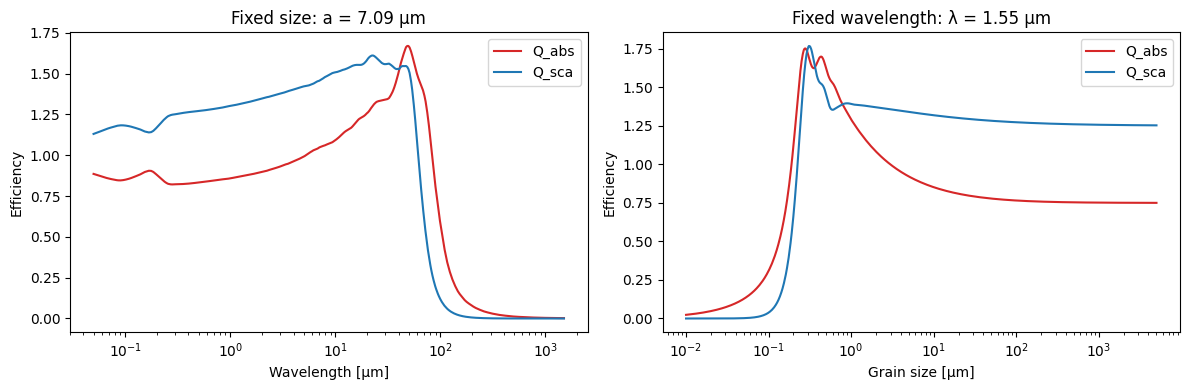

In [7]:
# Pick indices roughly in the middle of the arrays
i_size = len(sizes)//2
i_wave = len(waves)//3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Q vs wavelength at a fixed size
ax1.semilogx(waves, Q_abs[i_size,:], label='Q_abs', c='tab:red')
ax1.semilogx(waves, Q_sca[i_size,:], label='Q_sca', c='tab:blue')
ax1.set_xlabel('Wavelength [µm]')
ax1.set_ylabel('Efficiency')
ax1.set_title(f'Fixed size: a = {sizes[i_size]:.3g} µm')
ax1.legend()

# Q vs size at a fixed wavelength
ax2.semilogx(sizes, Q_abs[:,i_wave], label='Q_abs', c='tab:red')
ax2.semilogx(sizes, Q_sca[:,i_wave], label='Q_sca', c='tab:blue')
ax2.set_xlabel('Grain size [µm]')
ax2.set_ylabel('Efficiency')
ax2.set_title(f'Fixed wavelength: λ = {waves[i_wave]:.3g} µm')
ax2.legend()
plt.tight_layout()

## 4. 2D maps of Q_abs and Q_sca
Visualize both efficiencies as functions of wavelength and grain size (log-scaled axes).

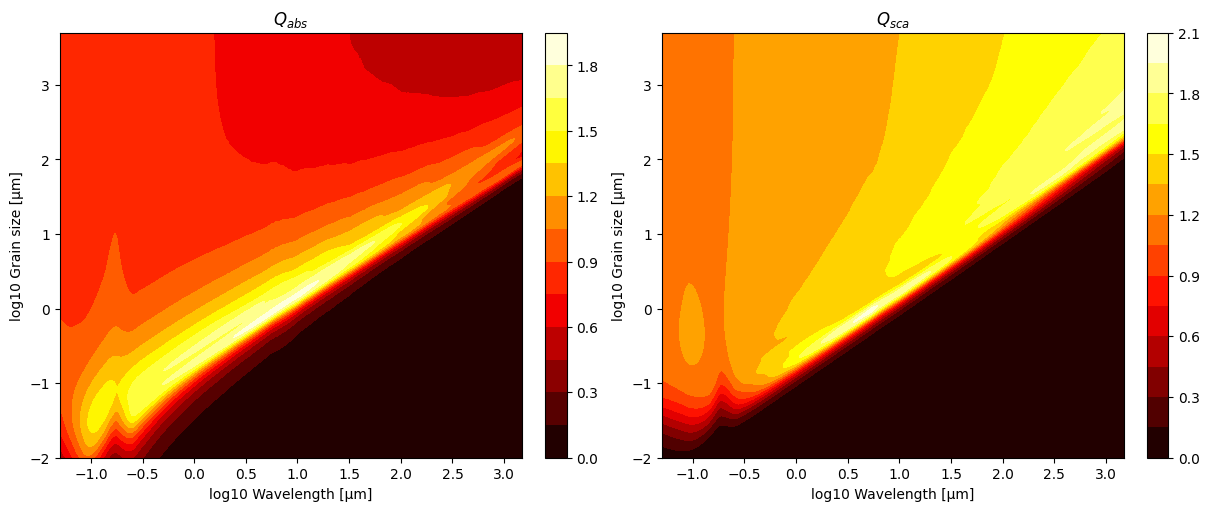

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

for ax, Q, title in zip(
    axes,
    [Q_abs, Q_sca],
    [r'$Q_{abs}$', r'$Q_{sca}$']
):
    im = ax.contourf(np.log10(waves), np.log10(sizes), Q, levels=15, cmap='hot')
    ax.set_xlabel('log10 Wavelength [µm]')
    ax.set_ylabel('log10 Grain size [µm]')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

plt.show()

Alternatively, you can use the built-in helper:
```python
grain.plot_Q()  # optional bounds: min_wave, max_wave, min_size, max_size
```

## 5. Materials and compositions
The composition name in `general.yaml` must exist in `parameters/material_list.txt`. Each entry defines optical and physical properties (e.g., sublimation temperature `Tsub`).

To explore available compositions:

In [9]:
from pyGrater import utils as utl
materials_path = Path(stgr.__file__).parent / 'parameters' / 'material_list.txt'
mat_dict = utl.import_material_properties(materials_path)
print("Available compositions:")
print(list(mat_dict.keys()))
print("\nCurrent composition:", grain.grain_composition_name)
print("Properties:")
for k, v in mat_dict[grain.grain_composition_name].items():
    print(f" - {k}: {v}")

Available compositions:
['enstatite', 'a_pyroxene_x=0.4', 'a_pyroxene_x=0.5', 'a_pyroxene_x=0.6', 'a_pyroxene_x=0.7', 'a_pyroxene_x=0.8', 'a_pyroxene_x=0.95', 'a_pyroxene_x=1.0', 'fayalite_Fabian01', 'fayalite_Suto02', 'c_olivine', 'a_forsterite', 'c_forsterite', 'olivine_x=0.4', 'olivine_x=0.5', 'silica', 'a_silica_10K', 'a_silica_100K', 'a_silica_200K', 'a_silica_300K', 'obsidian_L78_P73LittleGlassMt', 'obsidian_L78_P73LakeCoOregon', 'glassy_si', 'astroSi', 'SiC', 'aC_BE', 'aC_ACAR', 'aC_ACH2', 'graphite', 'org_refrac', 'H2O_Warren', 'aH2O', 'H2O_Li', 'FeO', 'FeS_10K', 'FeS_100K', 'FeS_200K', 'FeS_300K', 'Calcite_10K', 'Calcite_100K', 'Calcite_200K', 'Calcite_300K', 'Dolomite_10K', 'Dolomite_100K', 'Dolomite_200K', 'Dolomite_300K']

Current composition: aC_ACAR
Properties:
 - Nickname: aC_ACAR
 - Wav_min: 0.04008
 - Wav_max: 1984.0
 - Tsub: 2000.0
 - Density: 1.95
 - File_par: aC_ACAR.txt
 - File_per1: aC_ACAR.txt
 - File_per2: aC_ACAR.txt
 - Weight_par: 0.333333
 - Weight_per1: 0.33

To switch composition:
1. Edit `parameters/general.yaml` and set `composition: <YourMaterialName>`
2. Rebuild the `Grain` with `redo_Q=True` to regenerate efficiencies:
```python
grain = stgr.Grain(redo_Q=True)
```

## 6. Recompute Q after changing parameters
If you adjust the grid (`N_sizes`, `N_waves`, ranges), or the composition, force recomputation:
```python
grain = stgr.Grain(redo_Q=True)
```
This will populate the `efficiencies/` directory for later fast loading.

## 7. Summary
- Use `Grain` to access precomputed or recomputed `Q_abs` and `Q_sca` on a (size, wavelength) grid
- Control grid density and ranges via `parameters/general.yaml`
- Visualize 1D slices and 2D maps to understand scattering/absorption behavior
- Change composition in `general.yaml` and set `redo_Q=True` to update tables